In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import sys
import math
import sklearn
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

nltk.download('stopwords')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\David
[nltk_data]     Isaac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [365]:
df = pd.read_csv("datasets/cleaner_data.csv")
print(df.size)
df.head()

88767


,Unnamed: 0,name,multiverse_id,color_identity,text,flavor,power
0,1,Ancestor's Chosen,NaN,['W'],"First strike (This creature deals combat damage before creatures without first strike.)\r\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard.","""The will of all, by my hand done.""",4
1,2,Angel of Mercy,129465.0,['W'],"Flying\r\nWhen Angel of Mercy enters the battlefield, you gain 3 life.",Every tear shed is a drop of immortality.,3
2,4,Angelic Blessing,129711.0,['W'],Target creature gets +3/+3 and gains flying until end of turn. (It can't be blocked except by creatures with flying or reach.),Only the warrior who can admit mortal weakness will be bolstered by immortal strength.,NaN
3,6,Angelic Chorus,129710.0,['W'],"Whenever a creature enters the battlefield under your control, you gain life equal to its toughness.",The harmony of the glorious is a dirge to the wicked.,NaN
4,7,Angelic Wall,129671.0,['W'],Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't begin to comprehend.""\r\n—Mystic elder",0


In [366]:
def clean_color(text):
    # as cores são branco(W), preto(B), azul(U), vermelho(R) ou verde(G)
    pattern = r"\['(W|B|U|R|G)'\]"
    
    match = re.search(pattern, text)
    
    if match:
        return match.group(1)
    return None

df["color"] = df["color_identity"].apply(clean_color)
df.drop("color_identity", axis=1, inplace = True)

In [367]:
df["color"].value_counts()

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64

In [368]:
df["counterspell"] = (df.text.str.contains(r"[Cc]ounter\s(?:it|target|all)") & # anulações
         (df.text.str.contains(r"[wW]ard(?:\s{|—])") == False)) # Ward é uma maneira de anulação/proteção mais transversal às cores e é ignorada


df["exile"] = (df.text.str.contains(r"[eE]xile\s(?:target|each|all|the|up\sto)") & # exilar algo do tablueiro
        (df.text.str.contains(r"the\stop") == False)) # Algumas cartas "compram" cartas exilando-as do topo do deck, isso nào conta como exilar algo do tabuleiro

df["fight"] = (df.text.str.contains(r"[Ff]ights")) # Criaturas lutarem é uma mecânica característica do verde


df["mill"] = (df.text.str.contains(r"[mM]ill")) # TODO: mill é uma palavra chave recente, antes era referida por descartar a carta do >TOPO DO BATALHO<, bom adicionar este texto também


df["scry"] = (df.text.str.contains(r"[sS]cry"))


df["tap"] = (df.text.str.contains(r"(?:\st|T)ap\s(?:it|target|each|all|or\suntap)")) # cartas que viram outras 


df["untap"] = (df.text.str.contains(r"[uU]ntap\s(?:it|target|each|all)")) # find untappers

"""
df.loc[df.text.str.contains("[dD]eathtouch") | # find creatures that have deathtouch
        df.text.str.contains("deals combat damage to a creature, destroy that creature", regex = False)] # or that have "derptouch"
"""

df["double_strike"] = (df.text.str.contains(r"[dD]ouble\sstrike"))


df["first_strike"] = (df.text.str.contains(r"[fF]irst\sstrike"))


df["flash"] = (df.text.str.contains(r"(?:f|\nF|^F)lash") & # some engineering to avoid incorrectly grabbing cards with Flash in the name
        (df.text.str.contains(r"[fF]lashback") == False)) # dont' want to capture flashback


df["flying"] = (df.text.str.contains(r"[fF]lying"))


df["haste"] = (df.text.str.contains(r"[hH]aste"))


df["hexproof"] = (df.text.str.contains(r"[hH]exproof"))


df["indestructible"] = (df.text.str.contains(r"[iI]ndestructible") &
                         (df.text.str.contains(r"loses\sindestructible") == False))


df["sacrifice"] = (df.text.str.contains(r"[sS]acrifice"))


df["lifelink"] = (df.text.str.contains(r"[lL]ifelink"))


df["menace"] = (df.text.str.contains(r"[mM]enace"))


df["protection"] = (df.text.str.contains(r"[pP]rotection\sfrom"))


df["prowess"] = (df.text.str.contains(r"[pP]rowess"))


df["reach"] = (df.text.str.contains(r"(?:\sr|\nR|^R)each") &
        (df.text.str.contains(r"can't be blocked except by creatures with flying or reach", regex = False) == False)) # don't want flying reminder text


df["trample"] = (df.text.str.contains(r"[tT]rample"))


df["vigilance"] = (df.text.str.contains(r"[vV]igilance"))


df["draw"] = (df.text.str.contains(r"(?:\sd|\nD|^D)raw"))


df["discard"] = (df.text.str.contains(r"[dD]iscard"))


df["damage"] = (df.text.str.contains(r"deals\s\d\sdamage"))


df["damage_prevention"] = (df.text.str.contains(r"[pP]revent\s"))


df["life_gain"] = (df.text.str.contains(r"gain(?:\s|s\s)\d+\slife"))


df["life_loss"] = (df.text.str.contains(r"loses") & 
                   df.text.str.contains(r"(?:their|\d+)\slife")) # capture both fixed and rational values


df["tokens"] = (df.text.str.contains(r"[cC]reate"))


df["destroy"] = (df.text.str.contains(r"[dD]estroy") &
                  (df.text.str.contains(r"don't\sdestroy\sit.") == False)) # reject indestructible's reminder text


df["return"] = (df.text.str.contains(r"[rR]eturn") &
        df.text.str.contains(r"owner's\s(?:hand|library)") & # capture hand or library bounce effects
        (df.text.str.contains(r"graveyard\sto") == False)) # exclude grave recursion


df["recursion"] = (df.text.str.contains(r"\sput|return") &
        df.text.str.contains(r"graveyard")&
        df.text.str.contains(r"hand|battlefield"))



In [369]:
df.head()

,Unnamed: 0,name,multiverse_id,text,flavor,power,color,counterspell,exile,fight,...,draw,discard,damage,damage_prevention,life_gain,life_loss,tokens,destroy,return,recursion
0,1,Ancestor's Chosen,NaN,"First strike (This creature deals combat damage before creatures without first strike.)\r\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard.","""The will of all, by my hand done.""",4,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,2,Angel of Mercy,129465.0,"Flying\r\nWhen Angel of Mercy enters the battlefield, you gain 3 life.",Every tear shed is a drop of immortality.,3,W,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,4,Angelic Blessing,129711.0,Target creature gets +3/+3 and gains flying until end of turn. (It can't be blocked except by creatures with flying or reach.),Only the warrior who can admit mortal weakness will be bolstered by immortal strength.,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,6,Angelic Chorus,129710.0,"Whenever a creature enters the battlefield under your control, you gain life equal to its toughness.",The harmony of the glorious is a dirge to the wicked.,NaN,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7,Angelic Wall,129671.0,Defender (This creature can't attack.)\r\nFlying,"""The Ancestor protects us in ways we can't begin to comprehend.""\r\n—Mystic elder",0,W,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# STOP WORDS

In [370]:
#Evitar que fiquem cartas em outras linguas ou tokens compostos apenas por números

def remove_non_letter_words(text):
    # split do texto
    words = text.split()
    # Manter tokens que contenham ao menos uma letra
    clean_words = [word for word in words if re.search(r'[a-zA-Z]', word)]
    return ' '.join(clean_words)


df['flavor'] = df['flavor'].apply(remove_non_letter_words)

In [371]:
print("\nColunas e valores únicos:")
for coluna in df.columns:
    print(f"\nColuna: {coluna}")
    print(df[coluna].unique())


Colunas e valores únicos:

Coluna: Unnamed: 0
[    1     2     4 ... 76228 76231 76232]

Coluna: name
["Ancestor's Chosen" 'Angel of Mercy' 'Angelic Blessing' ...
 'Vastwood Fortification // Vastwood Thicket' 'Veteran Adventurer'
 'Vine Gecko']

Coluna: multiverse_id
[    nan 129465. 129711. ... 491866. 491869. 491870.]

Coluna: text
["First strike (This creature deals combat damage before creatures without first strike.)\r\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."
 'Flying\r\nWhen Angel of Mercy enters the battlefield, you gain 3 life.'
 "Target creature gets +3/+3 and gains flying until end of turn. (It can't be blocked except by creatures with flying or reach.)"
 ... 'When Turntimber Ascetic enters the battlefield, you gain 3 life.'
 'Veteran Adventurer is also a Cleric, Rogue, Warrior, and Wizard.\r\nThis spell costs {1} less to cast for each creature in your party.\r\nVigilance'
 'The first kicked spell you cast each turn co

In [372]:
print(df.dtypes)

Unnamed: 0             int64
name                  object
multiverse_id        float64
text                  object
flavor                object
power                 object
color                 object
counterspell            bool
exile                   bool
fight                 object
mill                  object
scry                  object
tap                   object
untap                 object
double_strike         object
first_strike          object
flash                   bool
flying                object
haste                 object
hexproof              object
indestructible          bool
sacrifice             object
lifelink              object
menace                object
protection            object
prowess               object
reach                   bool
trample               object
vigilance             object
draw                  object
discard               object
damage                object
damage_prevention     object
life_gain             object
life_loss     

In [373]:
df["flavor"] = df["flavor"].astype(str)  #meter os valores em str (algum poderia estar em numero, float, etc) - tendo em conta que flavor = object

#stop words tendo em conta a biblioteca NLTK (Natural Language Toolkit) English
stop_words = set(stopwords.words("english")) 

stop_words.update(["one", "never", "even", "every", "see"])  #stopwords que observamos durante a visualização dos dados que aparecia em todas as cores em grandes quantidades

In [374]:
def preprocess(text, stop_words): #fazemos o processamento de cada palavra de forma a ficar mais "pronta" para ser utilizada no processo de prever as cores
    #tirar as pontuações e meter tudo em minusculas
    text = re.sub(r'[^\w\s]', '', text.lower())  
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]#retirada de todas as stopwords
    return filtered_tokens

df["processed_flavor"] = df["flavor"].apply(lambda x: preprocess(x, stop_words)) #um lambda para utilizar a função preprocess em cada frase da coluna "processed_flavor"

print(df["processed_flavor"])

0                                                                                 [hand, done]
1                                                              [tear, shed, drop, immortality]
2                            [warrior, admit, mortal, weakness, bolstered, immortal, strength]
3                                                           [harmony, glorious, dirge, wicked]
4                       [ancestor, protects, us, ways, cant, begin, comprehend, mystic, elder]
                                                 ...                                          
12676                                            [standing, scythecat, prey, makes, appetizer]
12677    [long, land, cried, pain, flow, returns, balance, point, new, harmony, echoes, trees]
12678                         [understand, natures, ways, youre, unarmed, eyza, joraga, guide]
12679                                                                             [assistance]
12680        [cute, things, tend, get, lot, bigger

# TF IDF testes

In [375]:
df['processed_flavor'] = df['processed_flavor'].apply(lambda x: ' '.join(x)) #como o processed flavor vinha numa lista 
#(por culpa do processamento de retirada de stop words), houve a necessidade de voltar a juntar as palavras numa frase para se processeder a realização do TF IDF

In [376]:
X = df #todos os dados, mas o que nos queremos será o processed_Flavor
y = df['color'] #cor

df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#inicialmente, para vermos como as previsões estão a funcionar, houve a necessidade de fazer tambem a tabela do TF IDF só com o dataset de treino de forma a
#ver realmente como se comporta a previsão do tf idf com novos dados
#se o tfidf tivesse utilizado os dados todos das cartas, nao tinhamos dados para testar as previsões
#posteriormente decidimos acrescentar o resto das cartas para ter o dataset de previsão final utilizado para prever cartas novas e as suas cores
#quando utilizamos o data set todo, e pegamos em cartas ja existentes, a previsão chega a 0.70% o que é natural porque a frase ja existe dentro da tabela, o que nos queremos
#é ver como se comporta com frases que a mesma nunca teve interação mas que ja teve interação com palavras de outras frases

In [377]:
#de forma a termos os documentos como as cores, tivemos de juntar todas as cores em uma cor unica, as, imaginemos, 300 linhas com cor azul, passa a ser 1 linha de cor azul com as varias palavras que essa cor conteve
df_grouped = df_train.groupby('color')['processed_flavor'].apply(lambda x: ' '.join(x)).reset_index()

#Iniciamos o TfidfVectorizer e ajustamos consoante os textos agrupados por cor
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_grouped['processed_flavor'])

#Pegar na matriz do TFIDF e passar para dataframe, de forma a tornar mais facil utilizar e vizualizar os dados
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out(),
    index=df_grouped['color']
)

In [378]:
#queria meter uma tabela de 1D onde so mostra o valor de tfidf com maior valor de uma cor e certa palavra
tfidf_data = tfidf_df.stack().reset_index()
tfidf_data.columns = ['color', 'word', 'tfidf']
#ordenar os dados para ver o Top 20 
top_tfidf_all = tfidf_data.sort_values(by='tfidf', ascending=False).head(20)
print(top_tfidf_all)

      color     word     tfidf
3595      B    death  0.333731
23911     G   forest  0.245617
45113     R     like  0.212374
63158     U     like  0.208092
81190     W    light  0.206832
8991      B     life  0.206791
42549     R  goblins  0.199237
3575      B     dead  0.196553
70147     U     time  0.191907
63976     U     mind  0.182658
1585      B    blood  0.180174
67718     U      sea  0.175722
28364     G   nature  0.168481
27036     G     life  0.164421
27068     G     like  0.162392
89482     W      war  0.160193
81171     W     life  0.158166
62733     U     know  0.157225
9023      B     like  0.155605
22710     G    elves  0.153599


In [379]:
#agora queriamos ver os valores dessas mesmas palavras mas para todas as cores

#As 20 palavras mais "importantes"
top_20_words = top_tfidf_all['word'].unique()
filtered_tfidf = tfidf_df[top_20_words]
top_20_tfidf = filtered_tfidf.loc[df['color'].unique()]
print(top_20_tfidf)

          death    forest      like     light      life   goblins      dead  \
color                                                                         
W      0.101388  0.006083  0.123694  0.206832  0.158166  0.014194  0.054750   
U      0.055491  0.006936  0.208092  0.032370  0.076300  0.018497  0.032370   
B      0.333731  0.008190  0.155605  0.040949  0.206791  0.006142  0.196553   
R      0.072251  0.004379  0.212374  0.037220  0.070061  0.199237  0.045978   
G      0.081196  0.245617  0.162392  0.026389  0.164421  0.004060  0.034508   

           time      mind     blood       sea    nature       war      know  \
color                                                                         
W      0.105444  0.032444  0.050694  0.014194  0.008111  0.160193  0.075027   
U      0.191907  0.182658  0.023121  0.175722  0.036994  0.046243  0.157225   
B      0.094182  0.079850  0.180174  0.026617  0.022522  0.051186  0.077802   
R      0.089766  0.039410  0.131365  0.026273  0.02

In [380]:
#palavras a serem retiradas, a ideia é ver se existe palavras que tem a mesma importancia, ou parecida em todas as cores 
words_to_remove = []

for word in tfidf_df.columns:
    max_value = tfidf_df[word].max()
    intervalo = max_value / 4
    #calculamos o intervalor entre o max_value e os valores perto do mesmo, se nas outras cores a 
    #importancia tiver perto logo a palavra não é importante so para uma cor mas para varias, podendo nao ajudar na previsao das cores no futuro
    if all(tfidf_df[word].drop(index=tfidf_df[word].idxmax()) > max_value - intervalo): #excluimos o max_value da palavra atual durante a comparação
        words_to_remove.append(word)
# Remover as palavras identificadas
filtered_tfidf_df = tfidf_df.drop(columns=words_to_remove)

In [381]:
def remove_words(text, words_to_remove):
    #passar a palavras
    words = text.split()
    #remover as palavras que estão na lista 'words_to_remove'
    filtered_words = [word for word in words if word.lower() not in words_to_remove]
    #Junta as palavras restantes de volta em uma frase
    return ' '.join(filtered_words)
            
words_to_remove.append('color')
#para removermos as palavras anteriores tambem no proprio df
df_train['processed_flavor'] = df_train['processed_flavor'].apply(lambda x: remove_words(x, words_to_remove))
print("Palavras removidas:", words_to_remove)

Palavras removidas: ['best', 'blows', 'bottle', 'callapheia', 'city', 'community', 'defeating', 'designs', 'districts', 'giles', 'helping', 'laugh', 'listen', 'mercenary', 'otaria', 'permission', 'pie', 'psemilla', 'rathi', 'sees', 'strangers', 'wore', 'color']


In [382]:
all_words = []
for message in df['processed_flavor']:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

Number of words: 18657
Most common words: [('like', 419), ('life', 340), ('death', 323), ('world', 289), ('time', 288), ('dont', 281), ('us', 280), ('would', 265), ('must', 247), ('know', 244), ('many', 237), ('first', 225), ('may', 218), ('always', 216), ('could', 216)]


In [383]:
print(df['color'].value_counts())

color
W    2632
R    2575
B    2563
G    2475
U    2436
Name: count, dtype: int64


In [384]:
print(filtered_tfidf_df)

          115th     136iv   21june       22c     263rd    44to22        6d  \
color                                                                        
B      0.004297  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
G      0.000000  0.000000  0.00426  0.000000  0.000000  0.000000  0.000000   
R      0.000000  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000   
U      0.000000  0.000000  0.00000  0.000000  0.000000  0.004852  0.000000   
W      0.000000  0.004255  0.00000  0.004255  0.004255  0.000000  0.004255   

          962nd   aaahhhh     aagh  ...      zuo       zur     zurdi  \
color                               ...                                
B      0.000000  0.000000  0.00000  ...  0.00000  0.000000  0.000000   
G      0.000000  0.000000  0.00426  ...  0.00426  0.000000  0.006874   
R      0.004595  0.004595  0.00000  ...  0.00000  0.000000  0.000000   
U      0.000000  0.000000  0.00000  ...  0.00000  0.024261  0.003915   
W      0.000000  0.00

In [385]:
df_tfidf_prever = df_test.copy()

In [386]:
def calculate_color_score(tfidf_df, phrases): #previsão das cores tendo em conta os valores na tabela do tf idf
    #Todas as cores começam com 0 de pontuação
    color_scores = {color: 0 for color in tfidf_df.index}
    words = phrases.strip()  #Para nao termos espaços no início e fim das frases
    
    for word in words.split():  #Divide as palavras tendo em conta os espaços
        if word in tfidf_df.columns:
            for color in tfidf_df.index:
                #print('this is:', term, 'color',color,' pontuation:', tfidf_df.loc[color, term])  # Debug: verifique o termo completo
                color_scores[color] += tfidf_df.loc[color, word] #acrescenta a importancia de cada palavra a cor destinada a essa importancia
    print(color_scores)
    #função sigmoide
    color_scores = {color: 1 / (1 + math.exp(-score)) for color, score in color_scores.items()}
    return color_scores

In [387]:
df_tfidf_prever['test_color'] = df_tfidf_prever['processed_flavor'].apply(lambda phrase: calculate_color_score(filtered_tfidf_df, phrase))
#vemos a a cor com a maior pontuação para cada frase
df_tfidf_prever['predicted_color'] = df_tfidf_prever['test_color'].apply(lambda x: max(x, key=x.get))
#Calcula a precisão ao comparar a cor real com a cor prevista
accuracy = accuracy_score(df_tfidf_prever['color'], df_tfidf_prever['predicted_color'])
print(df_tfidf_prever[['processed_flavor', 'color', 'predicted_color']])
print(f"Acc: {accuracy:.2f}")


{'B': 0.007262165464276877, 'G': 0.029819737353983446, 'R': 0.013431532336763885, 'U': 0.026666856143905834, 'W': 0.010042356994607513}
{'B': 0.008391625905600547, 'G': 0.005466805851627579, 'R': 0.008973573741201234, 'U': 0.017971220922683204, 'W': 0.004055527263899693}
{'B': 0.004094862023813187, 'G': 0.013002421252046594, 'R': 0.05361323507047626, 'U': 0.004624256233000463, 'W': 0.019510858656584164}
{'B': 0.015698120805520868, 'G': 0.00959995421244339, 'R': 0.017537716534887143, 'U': 0.04535329533309386, 'W': 0.022029700265293044}
{'B': 0.10569219794167654, 'G': 0.16117105414460597, 'R': 0.1628898576304276, 'U': 0.18326335102336175, 'W': 0.25151234773451525}
{'B': 0.10804823472850589, 'G': 0.07327639065544694, 'R': 0.11603913100016998, 'U': 0.1435356222451504, 'W': 0.11698806566546927}
{'B': 0.13692290862864825, 'G': 0.07750610156850316, 'R': 0.12320769050773198, 'U': 0.10081500477675058, 'W': 0.13783536941977953}
{'B': 0.18094143556048106, 'G': 0.178630755279852, 'R': 0.1771492953

In [407]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Preparação dos dados
# Vamos assumir que "tfidf_df" contém os valores TF-IDF e "df['color']" contém as cores (classes).
X = filtered_tfidf_df  # Variáveis independentes (valores de TF-IDF)
y = df["color"]  # Variável dependente (cores)

# 2. Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Codificar as variáveis dependentes (se necessário)
# Se as cores são categóricas, vamos codificar as cores como números
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 4. Inicialização e treinamento do modelo de regressão logística
model = LogisticRegression(max_iter=1000)  # Ajuste de max_iter se necessário
model.fit(X_train, y_train_encoded)

# 5. Avaliação do modelo
y_pred = model.predict(X_test)

# Relatório de desempenho
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


ValueError: Found input variables with inconsistent numbers of samples: [5, 12681]

# REDE NEURONAL

In [388]:
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

# Preparar as variáveis X e y
X = np.array([list(color.values()) for color in df_tfidf_prever['test_color']])  # Converter os dicionários em listas de pontuações
y = df_tfidf_prever['color']

# Codificar as classes (cores) como números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Converter as labels para one-hot encoding
y_one_hot = to_categorical(y_encoded)

# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)
'''

"\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout\nfrom keras.utils import to_categorical\n\n# Preparar as variáveis X e y\nX = np.array([list(color.values()) for color in df_tfidf_prever['test_color']])  # Converter os dicionários em listas de pontuações\ny = df_tfidf_prever['color']\n\n# Codificar as classes (cores) como números\nlabel_encoder = LabelEncoder()\ny_encoded = label_encoder.fit_transform(y)\n\n# Converter as labels para one-hot encoding\ny_one_hot = to_categorical(y_encoded)\n\n# Dividir os dados em treino e teste (80% treino, 20% teste)\nX_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)\n"

In [389]:
'''
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
from keras.optimizers import SGD 
# Criar o modelo
model = Sequential()

# Camada de entrada com 128 neurônios e função de ativação 'relu'
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

# Camada oculta adicional 1
model.add(Dense(64, activation='relu'))

# Camada oculta adicional 2
model.add(Dense(32, activation='relu'))

# Camada de Dropout para prevenir overfitting
model.add(Dropout(0.2))

# Camada de saída com a função de ativação 'softmax' (para classificação multiclasse)
model.add(Dense(y_one_hot.shape[1], activation='softmax'))

# Compilar o modelo com o otimizador 'adam' e a função de perda 'categorical_crossentropy'
sgd_optimizer = SGD(learning_rate=0.01)  # Definindo a taxa de aprendizado do SGD
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()
'''

"\nimport pandas as pd\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import LabelEncoder\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout, Input\nfrom keras.utils import to_categorical\nfrom keras.optimizers import SGD \n# Criar o modelo\nmodel = Sequential()\n\n# Camada de entrada com 128 neurônios e função de ativação 'relu'\nmodel.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))\n\n# Camada oculta adicional 1\nmodel.add(Dense(64, activation='relu'))\n\n# Camada oculta adicional 2\nmodel.add(Dense(32, activation='relu'))\n\n# Camada de Dropout para prevenir overfitting\nmodel.add(Dropout(0.2))\n\n# Camada de saída com a função de ativação 'softmax' (para classificação multiclasse)\nmodel.add(Dense(y_one_hot.shape[1], activation='softmax'))\n\n# Compilar o modelo com o otimizador 'adam' e a função de perda 'categorical_crossentropy'\nsgd_optimizer = SGD(learning_rate=0.01)  # Definindo a

In [390]:
'''
# Treinar o modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))
'''

'\n# Treinar o modelo\nhistory = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test))\n'

In [391]:
'''
# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acc no conjunto de teste: {accuracy:.4f}')
'''

"\n# Avaliar o modelo\nloss, accuracy = model.evaluate(X_test, y_test)\nprint(f'Acc no conjunto de teste: {accuracy:.4f}')\n"

In [392]:
'''
# Fazer previsões com novos dados (aqui usamos X_test como exemplo)
y_pred = model.predict(X_test)

# Converter a previsão (vetor de probabilidades) para a classe com maior probabilidade
y_pred_classes = np.argmax(y_pred, axis=1)

# Decodificar a classe de volta para a cor
predicted_colors = label_encoder.inverse_transform(y_pred_classes)

# Mostrar as previsões
print(f'Previsões: {predicted_colors}')
'''

"\n# Fazer previsões com novos dados (aqui usamos X_test como exemplo)\ny_pred = model.predict(X_test)\n\n# Converter a previsão (vetor de probabilidades) para a classe com maior probabilidade\ny_pred_classes = np.argmax(y_pred, axis=1)\n\n# Decodificar a classe de volta para a cor\npredicted_colors = label_encoder.inverse_transform(y_pred_classes)\n\n# Mostrar as previsões\nprint(f'Previsões: {predicted_colors}')\n"

# PREVISOES COM FEATURES

In [393]:
df_prever = df.copy()

In [394]:
df_prever.columns

Index(['Unnamed: 0', 'name', 'multiverse_id', 'text', 'flavor', 'power',
       'color', 'counterspell', 'exile', 'fight', 'mill', 'scry', 'tap',
       'untap', 'double_strike', 'first_strike', 'flash', 'flying', 'haste',
       'hexproof', 'indestructible', 'sacrifice', 'lifelink', 'menace',
       'protection', 'prowess', 'reach', 'trample', 'vigilance', 'draw',
       'discard', 'damage', 'damage_prevention', 'life_gain', 'life_loss',
       'tokens', 'destroy', 'return', 'recursion', 'processed_flavor'],
      dtype='object')

In [395]:
df_prever = df_prever.drop(columns=['Unnamed: 0', 'multiverse_id','text','flavor','processed_flavor','name'])

In [396]:
df_prever.isnull().sum()

power                5310
color                   0
counterspell            0
exile                   0
fight                 289
mill                  289
scry                  289
tap                   289
untap                 289
double_strike         289
first_strike          289
flash                   0
flying                289
haste                 289
hexproof              289
indestructible          0
sacrifice             289
lifelink              289
menace                289
protection            289
prowess               289
reach                   0
trample               289
vigilance             289
draw                  289
discard               289
damage                289
damage_prevention     289
life_gain             289
life_loss               0
tokens                289
destroy                 0
return                  0
recursion               0
dtype: int64

In [397]:
df_prever = df_prever.dropna() 

In [398]:
# Convertendo colunas booleanas em 0 e 1
boolean_columns = ['counterspell', 'exile', 'fight', 'mill', 'scry', 'tap', 'untap', 
                   'double_strike', 'first_strike', 'flash', 'flying', 'haste', 'hexproof', 
                   'indestructible', 'sacrifice', 'lifelink', 'menace', 'protection', 'prowess', 
                   'reach', 'trample', 'vigilance', 'draw', 'discard', 'damage', 'damage_prevention', 
                   'life_gain', 'life_loss', 'tokens', 'destroy', 'return', 'recursion']

# Convertendo as colunas booleanas para inteiros (0 ou 1)
df_prever[boolean_columns] = df_prever[boolean_columns].astype(int)

# Mapeando as cores para números
color_mapping = {
    'G': 1,  # Verde
    'R': 2,  # Vermelho
    'U': 3,  # Azul
    'W': 4,  # Branco
    'B': 5   # Preto
}

# Aplicando o mapeamento à coluna 'color'
df_prever['color'] = df_prever['color'].map(color_mapping)
# Caso a coluna 'color' tenha valores ausentes ou errados, podemos tratar com um valor padrão, por exemplo, 0
df_prever['color'] = df_prever['color'].fillna(0).astype(int)

# Tratando a coluna 'power' (convertendo para float, se necessário)
# Se a coluna 'power' contiver valores de texto como '*', podemos substituir por NaN antes da conversão
df_prever['power'] = pd.to_numeric(df_prever['power'], errors='coerce')

# Verificando o resultado
print(df_prever.head())

   power  color  counterspell  exile  fight  mill  scry  tap  untap  \
0    4.0      4             0      0      0     0     0    0      0   
1    3.0      4             0      0      0     0     0    0      0   
4    0.0      4             0      0      0     0     0    0      0   
6    2.0      4             0      0      0     0     0    0      0   
7    2.0      4             0      0      0     0     0    0      0   

   double_strike  ...  draw  discard  damage  damage_prevention  life_gain  \
0              0  ...     0        0       0                  0          1   
1              0  ...     0        0       0                  0          1   
4              0  ...     0        0       0                  0          0   
6              0  ...     0        0       0                  0          0   
7              0  ...     0        0       0                  0          0   

   life_loss  tokens  destroy  return  recursion  
0          0       0        0       0          0  
1 

In [399]:
df_prever.columns

Index(['power', 'color', 'counterspell', 'exile', 'fight', 'mill', 'scry',
       'tap', 'untap', 'double_strike', 'first_strike', 'flash', 'flying',
       'haste', 'hexproof', 'indestructible', 'sacrifice', 'lifelink',
       'menace', 'protection', 'prowess', 'reach', 'trample', 'vigilance',
       'draw', 'discard', 'damage', 'damage_prevention', 'life_gain',
       'life_loss', 'tokens', 'destroy', 'return', 'recursion'],
      dtype='object')

In [400]:
print(df_prever.dtypes)

power                float64
color                  int32
counterspell           int32
exile                  int32
fight                  int32
mill                   int32
scry                   int32
tap                    int32
untap                  int32
double_strike          int32
first_strike           int32
flash                  int32
flying                 int32
haste                  int32
hexproof               int32
indestructible         int32
sacrifice              int32
lifelink               int32
menace                 int32
protection             int32
prowess                int32
reach                  int32
trample                int32
vigilance              int32
draw                   int32
discard                int32
damage                 int32
damage_prevention      int32
life_gain              int32
life_loss              int32
tokens                 int32
destroy                int32
return                 int32
recursion              int32
dtype: object


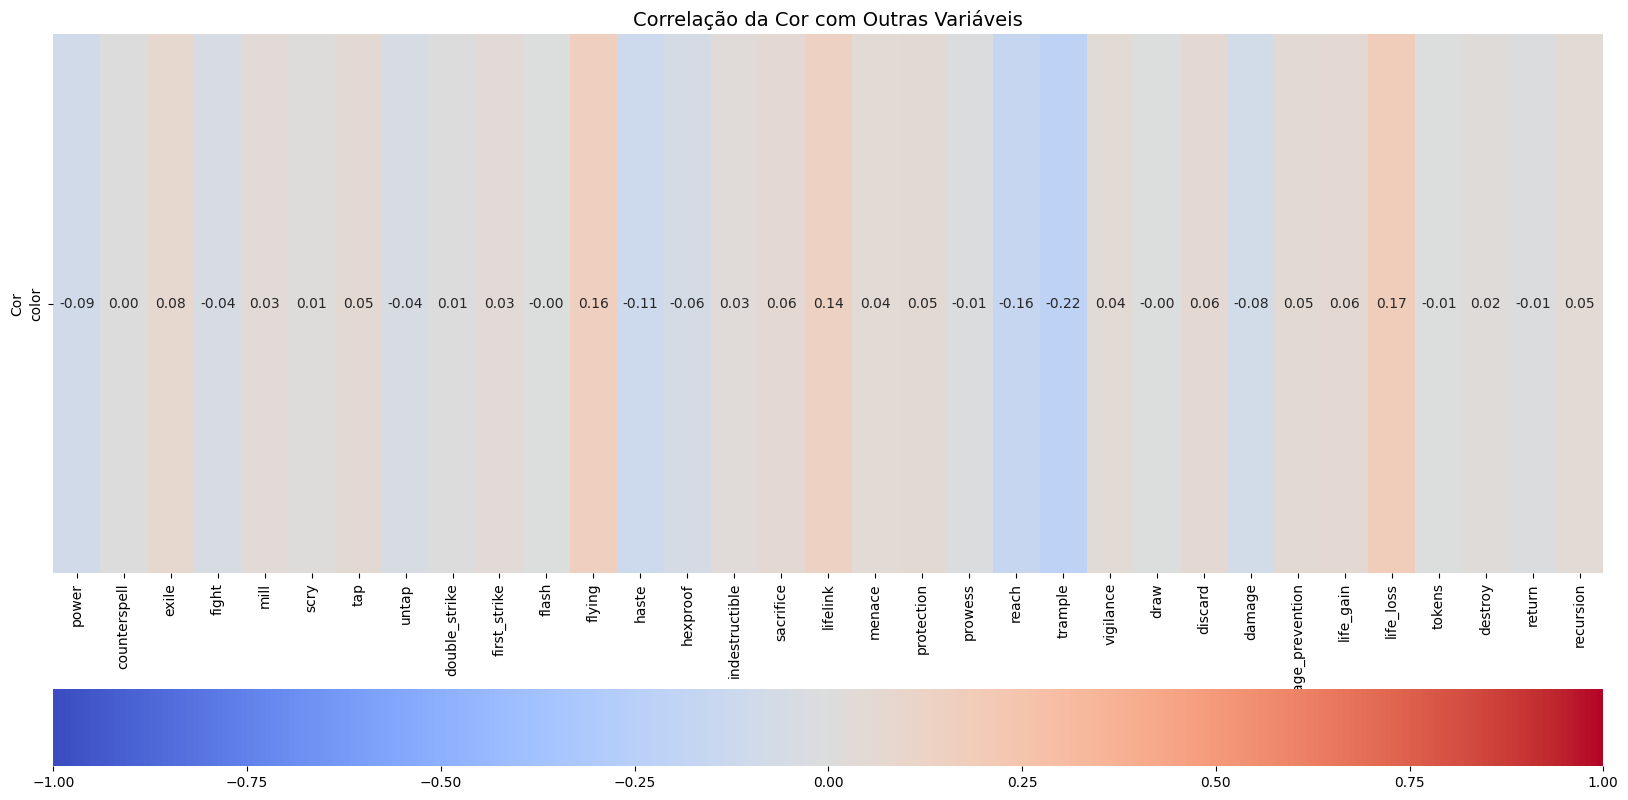

In [401]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar colunas relevantes
selected_columns = ['color', 'counterspell', 'flying', 'haste', 'hexproof', 'indestructible', 
                    'lifelink', 'menace', 'protection', 'trample', 'vigilance', 'damage']

# Subset do DataFrame com as colunas selecionadas
df_selected = df_prever

# Calcular a matriz de correlação
correlation_matrix = df_selected.corr()

# Focar apenas nas correlações da variável `color` com as outras
color_correlation = correlation_matrix.loc[['color'], correlation_matrix.columns != 'color']

# Criar o heatmap
plt.figure(figsize=(20, 10))  # Tamanho ajustado para o gráfico horizontal
sns.heatmap(color_correlation, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, cbar_kws={'orientation': 'horizontal'})
plt.title('Correlação da Cor com Outras Variáveis', fontsize=14)
plt.xlabel('Variáveis')
plt.ylabel('Cor')
plt.show()



In [402]:
df_prever_ml = df_prever[['exile', 'flying', 'lifelink', 'life_loss','color']]

In [403]:
from sklearn.model_selection import train_test_split

X = df_prever_ml.drop('color', axis=1)  # Atributos
y = df_prever_ml['color']  # Alvo (cor da carta)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [404]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [405]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Acurácia: 0.3048694424841214
              precision    recall  f1-score   support

           1       0.27      0.94      0.42       314
           2       0.00      0.00      0.00       277
           3       0.36      0.38      0.37       256
           4       0.56      0.06      0.11       298
           5       0.92      0.08      0.15       272

    accuracy                           0.30      1417
   macro avg       0.42      0.29      0.21      1417
weighted avg       0.42      0.30      0.21      1417



C:\Users\David Isaac\OneDrive - ISCTE-IUL\Ambiente de Trabalho\3_Ano_IA\text_mining\projeto_text_magic\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\David Isaac\OneDrive - ISCTE-IUL\Ambiente de Trabalho\3_Ano_IA\text_mining\projeto_text_magic\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\David Isaac\OneDrive - ISCTE-IUL\Ambiente de Trabalho\3_Ano_IA\text_mining\projeto_text_magic\ml_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarnin

# WORLD CLOUD

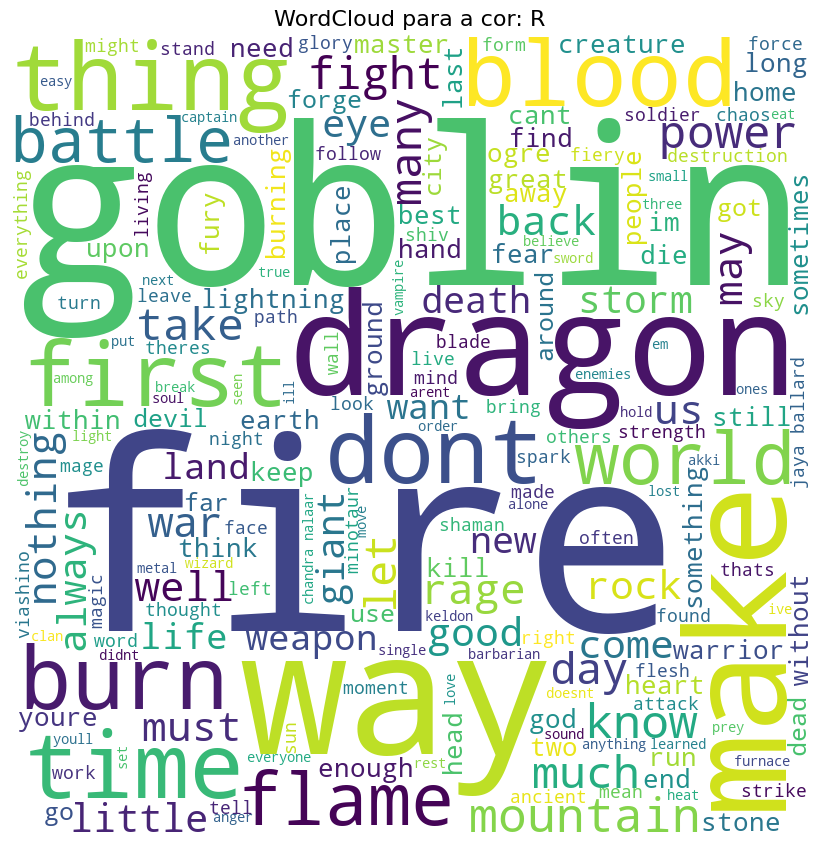

In [406]:
# Função para gerar o WordCloud para uma cor específica
def gerar_wordcloud_cor(cor, df):
    # Filtra as linhas onde a coluna 'color' contém a cor desejada
    filtered_words = df[df['color'].str.contains(cor, case=False, na=False)]['processed_flavor']

    # Cria uma string com todas as palavras filtradas
    comment_words = ' '.join(filtered_words)

    # Verifica se há palavras filtradas antes de gerar o WordCloud
    if comment_words:
        # Gerar o WordCloud com o texto filtrado
        wordcloud = WordCloud(width=800, height=800,
                              background_color='white',
                              stopwords=STOPWORDS,
                              min_font_size=10).generate(comment_words)

        # Exibe a imagem do WordCloud para a cor
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.tight_layout(pad=0)

        # Adiciona título com o nome da cor
        plt.title(f"WordCloud para a cor: {cor}", fontsize=16)
        plt.show()
    else:
        print(f"Não há palavras associadas à cor: {cor}")

# Escolha a cor desejada para o WordCloud
cor_escolhida = 'R'  # Exemplo: 'red', pode substituir por qualquer cor

# Chama a função para gerar o WordCloud para a cor escolhida
gerar_wordcloud_cor(cor_escolhida, df)
